**LAXICON BASED APPROCH**

In [ ]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [96]:

# Load the dataset
df = pd.read_csv("dataset.csv")

In [97]:
# 1. Statistical Summary
print("Descriptive Statistics:")
print(df[['review__confidence', 'review_evaluation']].describe())

Descriptive Statistics:
       review__confidence  review_evaluation
count          403.000000         405.000000
mean             3.573201           0.182716
std              0.844341           1.502868
min              1.000000          -2.000000
25%              3.000000          -1.000000
50%              4.000000           0.000000
75%              4.000000           2.000000
max              5.000000           2.000000


In [98]:

# 2. Correlation Analysis
correlation_matrix = df[['review__confidence', 'review_evaluation']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)



Correlation Matrix:
                    review__confidence  review_evaluation
review__confidence            1.000000          -0.038315
review_evaluation            -0.038315           1.000000


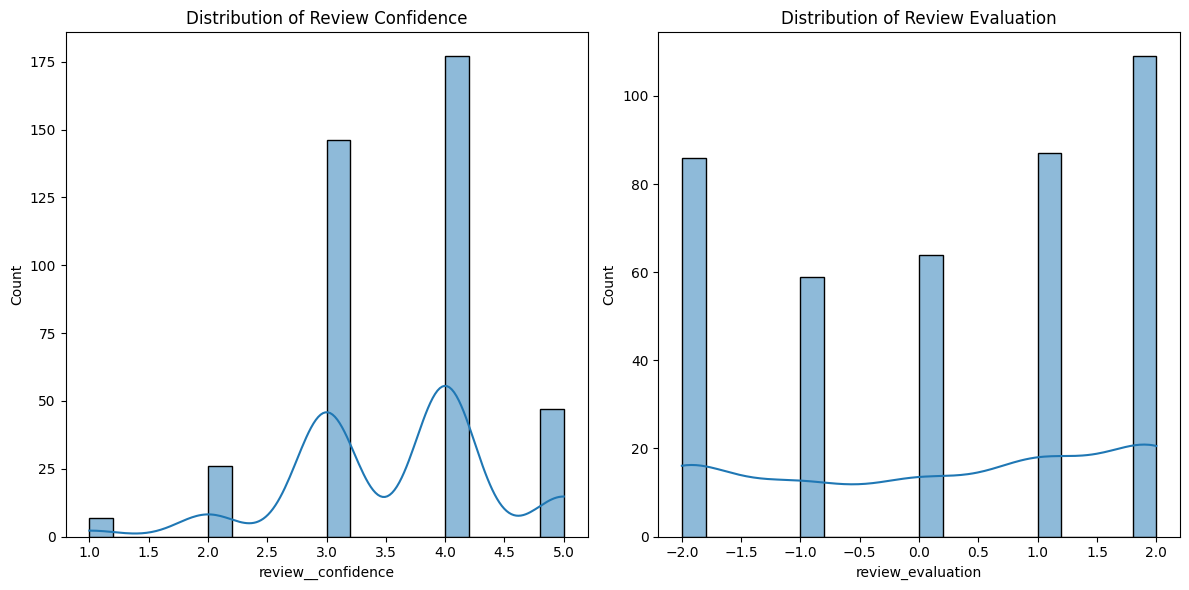

In [99]:
# 3. Visualization
# Histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='review__confidence', kde=True, bins=20)
plt.title('Distribution of Review Confidence')
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='review_evaluation', kde=True, bins=20)
plt.title('Distribution of Review Evaluation')
plt.tight_layout()
plt.show()


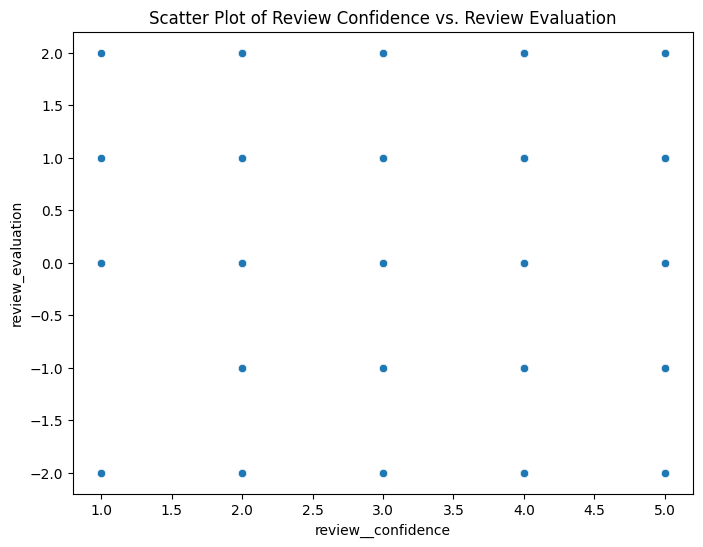

In [100]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='review__confidence', y='review_evaluation')
plt.title('Scatter Plot of Review Confidence vs. Review Evaluation')
plt.show()

In [101]:
# Count the number of papers for each preliminary decision
prelim_decision_counts = df['preliminary_decision'].value_counts()
print(prelim_decision_counts)


preliminary_decision
accept             115
reject              48
probably reject      7
no decision          2
Name: count, dtype: int64


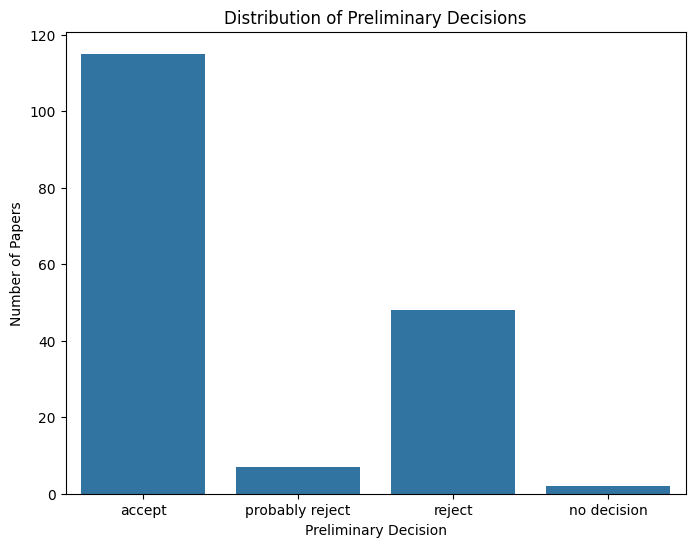

In [102]:


# Visualize the distribution of preliminary decisions
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='preliminary_decision')
plt.xlabel('Preliminary Decision')
plt.ylabel('Number of Papers')
plt.title('Distribution of Preliminary Decisions')
plt.show()


In [103]:
sid = SentimentIntensityAnalyzer()
sentiments = []
for review in df['review__text']:
    # Convert the review text to string explicitly
    review = str(review)
    sentiment_score = sid.polarity_scores(review)
    sentiments.append(sentiment_score)
# Add sentiment scores to the DataFrame
df['sentiment'] = sentiments

In [104]:
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment classification to compound scores
df['sentiment_class'] = df['sentiment'].apply(lambda x: classify_sentiment(x['compound']))

# Optionally, you can save the DataFrame with sentiment scores and classifications
df.to_csv("sentiment_analyzed_reviews.csv", index=False)


In [105]:
# Calculate summary statistics of sentiment scores
summary_stats = df['sentiment'].apply(lambda x: x['compound']).describe()
print(summary_stats)


count    408.000000
mean       0.343685
std        0.578401
min       -0.987300
25%       -0.006450
50%        0.553750
75%        0.846100
max        0.997300
Name: sentiment, dtype: float64


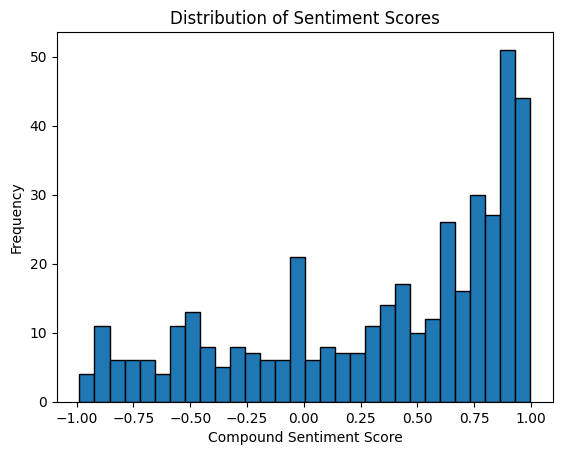

In [106]:


# Visualize the distribution of sentiment scores
plt.hist(df['sentiment'].apply(lambda x: x['compound']), bins=30, edgecolor='black')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()


In [107]:
# Count the number of reviews in each sentiment class
sentiment_counts = df['sentiment_class'].value_counts()
print(sentiment_counts)


sentiment_class
Positive    283
Negative    101
Neutral      24
Name: count, dtype: int64


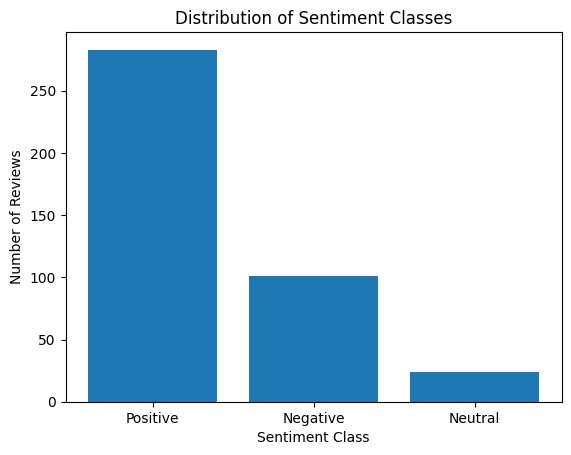

In [108]:
# Visualize the distribution of sentiment classes
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Classes')
plt.show()


In [109]:
# Display sample reviews with sentiment classifications
sample_reviews = df.sample(5)  # Change 5 to the desired number of reviews
for index, row in sample_reviews.iterrows():
    print(f"Review: {row['review__text']}")
    print(f"Sentiment Classification: {row['sentiment_class']}")
    print()


Review: The article is about the application of BPMN to understand a business process in a mining company in Peru. The document is well structured and easy to read. Few editorial errors are observed. Furthermore, its format is that required by Congress. In relation to the topic of the article, being an application of BPMN, it is not new. From the case, I believe that it was possible to make a greater contribution, perhaps proposing a methodology to address the review of business processes, considering that the internal and external actors of the company generally prioritize the optimization of their production processes more than the review. of other processes. Last but not least, the emphasis of the article is the review (audit) of the process with BPMN, moving away from the themes of the congress. Greater emphasis could be given to applications associated with the congress, such as requirements analysis from BPMN, SOA implementation from BPMN, process monitoring with BAM and BPMN, et

**MACHINE LEARNING APPROCH**

**SUPPORT VECTOR MACHINE**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, precision_score




In [111]:
# Load the dataset
df = pd.read_csv("dataset.csv")


In [112]:

# Preprocessing - handling missing values, etc. if needed
# Drop rows with missing values
df.dropna(subset=['review__text', 'preliminary_decision'], inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review__text'], df['preliminary_decision'], test_size=0.2, random_state=42)

In [113]:

# Define the pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Use TF-IDF for feature extraction
    ('svm', SVC())  # SVM classifier
])


In [114]:
# Define the parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Try different n-gram ranges
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf', 'poly']
}

In [115]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)


C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf', 'poly'],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]})

In [116]:
# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


Best Accuracy: 0.7256410256410255
Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'tfidf__ngram_range': (1, 1)}


In [117]:


# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

# Predictions with the best model
best_model = grid_search.best_estimator_
svm_predictions = best_model.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted') # Precision for each class, weighted by support
print("Support Vector Machine (SVM) Classifier Accuracy:", svm_accuracy)
print("Support Vector Machine (SVM) Classifier Precision:", svm_precision)
print("Support Vector Machine (SVM) Classifier Report:")
print(classification_report(y_test, svm_predictions))


C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Accuracy: 0.7256410256410255
Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf', 'tfidf__ngram_range': (1, 1)}
Support Vector Machine (SVM) Classifier Accuracy: 0.8181818181818182
Support Vector Machine (SVM) Classifier Precision: 0.8268398268398268
Support Vector Machine (SVM) Classifier Report:
                 precision    recall  f1-score   support

         accept       0.79      1.00      0.88        22
probably reject       0.00      0.00      0.00         1
         reject       1.00      0.50      0.67        10

       accuracy                           0.82        33
      macro avg       0.60      0.50      0.52        33
   weighted avg       0.83      0.82      0.79        33



C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

**NAIVE BAYES ALGORITHM**

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, classification_report

In [119]:

# Drop rows with missing values
df.dropna(subset=['review__text', 'preliminary_decision'], inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review__text'], df['preliminary_decision'], test_size=0.2, random_state=42)

In [120]:

# Define the pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Use TF-IDF for feature extraction
    ('nb', MultinomialNB())  # Naive Bayes classifier
])


In [121]:
# Define the parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Try different n-gram ranges
    'nb__alpha': [0.1, 1, 10]  # Smoothing parameter for Naive Bayes
}


In [122]:

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=nb_pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]})

In [123]:
# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

Best Accuracy: 0.6794871794871795
Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}


In [124]:
# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.6666666666666666


In [125]:
# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print some predictions
print("Some predictions:")
for i in range(5):
    print("Review:", X_test.iloc[i])
    print("True Label:", y_test.iloc[i])
    print("Predicted Label:", y_pred[i])
    print()

Precision: 0.4444444444444444
Classification Report:
                 precision    recall  f1-score   support

         accept       0.67      1.00      0.80        22
probably reject       0.00      0.00      0.00         1
         reject       0.00      0.00      0.00        10

       accuracy                           0.67        33
      macro avg       0.22      0.33      0.27        33
   weighted avg       0.44      0.67      0.53        33

Some predictions:
Review: The article presents the development of a mobile application, it does not include any element of research associated with said development. It simply focuses on the application of the RUP process for development. The texts or articles used for definitions or assertions made, for example, about RUP are not referenced "....it is focused on "diagrams of use cases, and risk management and management of the architecture" as such " If it is in circles, I assume it is a verbatim copy of some part that is not indicated. A

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

**RANDOM FOREST ALGORITHM**

In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, classification_report


In [129]:
# Define the pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),  # Increase max_features
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))  # Increase n_estimators
])


In [130]:
# Define the parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

In [131]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000)),
                                       ('classifier',
                                        RandomForestClassifier(n_estimators=200,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [132]:
# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

# Predict on the test set using the best model from GridSearchCV
rf_predictions = grid_search.predict(X_test)

Best Accuracy: 0.42018849206349207
Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300, 'tfidf__ngram_range': (1, 3)}


In [133]:
# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

# Calculate precision
rf_precision = precision_score(y_test, rf_predictions, average='weighted')
print("Random Forest Precision:", rf_precision)

Random Forest Accuracy: 0.3625
Random Forest Precision: 0.2532514992503748


C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [134]:
# Print classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Make some predictions
example_texts = [
    "This paper is good",
    "I don't like this paper at all.",
    "The description is excellent but the content was poor.",
    "I'm satisfied with this paper explanation ."
]
example_predictions = grid_search.predict(example_texts)
for text, prediction in zip(example_texts, example_predictions):
    print(f"Text: {text} --> Prediction: {prediction}")

# Optionally, you can visualize the results or perform additional analysis

Random Forest Classification Report:
              precision    recall  f1-score   support

        -2.0       0.28      0.62      0.38        13
        -1.0       0.00      0.00      0.00        10
         0.0       0.00      0.00      0.00        16
         1.0       0.40      0.10      0.16        20
         2.0       0.41      0.90      0.57        21

    accuracy                           0.36        80
   macro avg       0.22      0.32      0.22        80
weighted avg       0.25      0.36      0.25        80

Text: This paper is good --> Prediction: 2.0
Text: I don't like this paper at all. --> Prediction: 2.0
Text: The description is excellent but the content was poor. --> Prediction: 2.0
Text: I'm satisfied with this paper explanation . --> Prediction: 2.0


C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati